<h1>Extracellular reaction-diffusion tutorial</h1>
We have expanded the capabilities the NEURON reaction diffusion module to support a macroscopic model of the extracellular space, described in a recent <a href=https://doi.org/10.3389/fninf.2018.00041>paper</a>. Here is brief a tutorial that provides an overview of the python interface.

In [1]:
%%capture
!nrnivmodl

Compile the mod file used in this tutorial.

In [2]:
from neuron import h, crxd as rxd

For reaction diffusion in the extracellular space (ECS) you have to import the crxd from neuron. The first example we will place two single compartment neurons in a closed box of extracellular space.

In [3]:
rxd.options.enable.extracellular=True

To use extracellular reaction diffusion it must be enabled, it is enabled by default in NEURON 7.7 or later.

In [4]:
rxd.nthread(4)

4

Extracellular rxd supports multithreaded parallelization.

In [5]:
h.load_file('stdrun.hoc')
h.load_file('import3d.hoc')
class Cell:
    def __init__(self,filename):
        """Read geometry from a given SWC file and create a cell with a K+ source"""
        cell = h.Import3d_SWC_read()
        cell.input(filename)
        h.Import3d_GUI(cell, 0)
        i3d = h.Import3d_GUI(cell, 0)
        i3d.instantiate(self)
        for sec in self.all:
            sec.nseg = 1 + 10 * int(sec.L / 5)
            sec.insert('steady_k')
    def extrema(self):
        """Give the bounding box that contains the cell"""
        xlo = ylo = zlo = xhi = yhi = zhi = None
        for sec in self.all:
            n3d = sec.n3d()
            xs = [sec.x3d(i) for i in range(n3d)]
            ys = [sec.y3d(i) for i in range(n3d)]
            zs = [sec.z3d(i) for i in range(n3d)]
            my_xlo, my_ylo, my_zlo = min(xs), min(ys), min(zs)
            my_xhi, my_yhi, my_zhi = max(xs), max(ys), max(zs)
            if xlo is None:
                xlo, ylo, zlo = my_xlo, my_ylo, my_zlo
                xhi, yhi, zhi = my_xhi, my_yhi, my_zhi
            else:
                xlo, ylo, zlo = min(xlo, my_xlo), min(ylo, my_ylo), min(zlo, my_zlo)
                xhi, yhi, zhi = max(xhi, my_xhi), max(yhi, my_yhi), max(zhi, my_zhi)
        return (xlo, ylo, zlo, xhi, yhi, zhi)

In [6]:
try:
    from urllib import urlretrieve
except:
    from urllib.request import urlretrieve
#urlretrieve ("http://neuromorpho.org/dableFiles/amaral/CNG%20version/c91662.CNG.swc", "c91662.swc")
mycell = Cell('c91662.swc')

One point section Import3d_Section[2] ending at line 10 has been removed
One point section Import3d_Section[1] ending at line 9 has been removed


Create a cell from the given SWC file, in this example we use a <a href="http://neuromorpho.org/neuron_info.jsp?neuron_name=c91662at">CA1 pyramidal cell</a> taken from NeuroMorpho.Org. We insert a current source `steady_k` into all sections as a simple proof of concept example.

In [7]:
xlo, ylo, zlo, xhi, yhi, zhi = mycell.extrema()
padding = 100
ecs = rxd.Extracellular(xlo - padding, ylo - padding, zlo - padding,
                        xhi + padding, yhi + padding, zhi + padding,
                        dx=(20, 20, 50), volume_fraction=0.2, tortuosity=1.6)

We define the extracellular region by specifying the left-bottom-back corner and right-upper-front corner of a box with voxel size dx$\times$dy$\times$dz, (if only one value is given the voxels are cubic).
We use a macroscopic volume average approach, where the volume fraction or porosity is the free space in which particles can diffuse (typically 0.2 in the brain) and the tortuosity is the increase in path length particles take due to obstacles.

In [8]:
k = rxd.Species(ecs, d=2.62, name='k', charge=1, initial=3, ecs_boundary_conditions=3)

The species diffusing in the ECS are define in the same was as intracellular species.

The extracellular concentrations are accessible by `states3d`. Here we animate the concentrations during a 20s simulation.

In [9]:
from matplotlib import pyplot, animation
from IPython.display import HTML

# use a large timestep as this model only has slow diffusive dynamics.
h.dt = 20

#Create an animation of average (over depth) of the concentrations
def runsim(species, min_conc=3, max_conc=4, frames=1000):
    h.finitialize()
    fig = pyplot.figure()
    im = pyplot.imshow(species[ecs].states3d.mean(2), vmin=min_conc, vmax=max_conc)
    pyplot.axis('off')

    def init():
        im.set_data(species[ecs].states3d.mean(2))
        return [im]
    def animate(i):
        h.fadvance()
        im.set_data(species[ecs].states3d.mean(2))
        return [im]

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=10)
    ret =  HTML(anim.to_html5_video())
    pyplot.close()
    return ret

In [10]:
runsim(k, min_conc=0, max_conc=4)

states
states
states


20000.0

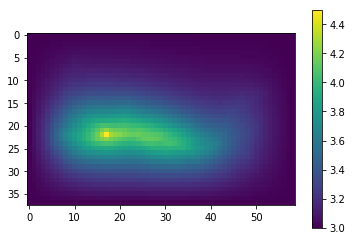

In [11]:
pyplot.imshow(k[ecs].states3d.mean(2))
pyplot.colorbar()
import numpy
states = numpy.copy(k[ecs].states3d)
h.t

In [12]:
h.CVode().active(True)
h.finitialize(-70)
h.CVode().event(20000)
h.continuerun(20000)

states
states


0.0

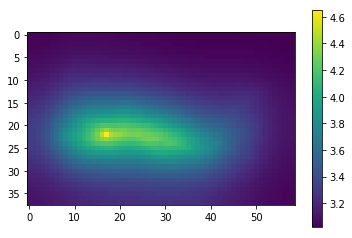

In [13]:
pyplot.imshow(k[ecs].states3d.mean(2))
pyplot.colorbar()

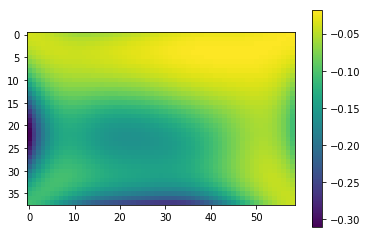

In [14]:
diff = states-k[ecs].states3d;
pyplot.imshow(diff.mean(2))
pyplot.colorbar()


In [16]:
k[ecs].states3d[-1,:,:]

array([[3.02595605, 3.03281437, 3.0465902 , 3.06697451, 3.09256967,
        3.12018888, 3.14479791, 3.1607369 , 3.16424478, 3.15572282,
        3.14004927, 3.12425291, 3.1145895 ],
       [3.02621167, 3.03316941, 3.04715731, 3.06789402, 3.09398889,
        3.12223464, 3.1474817 , 3.16390222, 3.16756216, 3.15883399,
        3.14273396, 3.12651652, 3.11659952],
       [3.02671236, 3.03386246, 3.04826956, 3.06968987, 3.09677207,
        3.12623828, 3.15275309, 3.17011556, 3.17409346, 3.164953  ,
        3.14802411, 3.13097321, 3.12056122],
       [3.0274355 , 3.03486686, 3.04987378, 3.07229233, 3.10079304,
        3.13204755, 3.16039877, 3.17916644, 3.18360987, 3.17389312,
        3.15574744, 3.13749337, 3.1263565 ],
       [3.02835207, 3.03613524, 3.05190962, 3.07558014, 3.10589631,
        3.13940966, 3.17013797, 3.19070774, 3.19580264, 3.18534748,
        3.165672  , 3.14587299, 3.13381813],
       [3.02942215, 3.03762135, 3.05428188, 3.07943007, 3.11185142,
        3.14804303, 3.18156

<h3>Recording from a single voxel</h3>
We can also record from the extracellular concentration in the same way other NEURON states are recorded. Here we record from a extracellular node by access it by location or index into the states3d matrix.

states
states


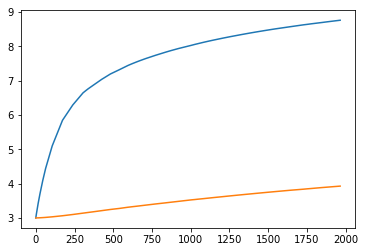

In [16]:
# record from an extracellular nodes given by the x,y,z location
kecs_vec0 = h.Vector()
kecs_vec0.record(k[ecs].node_by_location(0, 0, 0)._ref_value) # same as k[ecs].node_by_ijk(20,15,7)

# record the same node by it's index into stated3d
kecs_vec1 = h.Vector()
kecs_vec1.record(k[ecs].node_by_ijk(22, 15, 7)._ref_value) # same as k[ecs].node_by_location(50,0,0)

# record the time
t_vec = h.Vector()
t_vec.record(h._ref_t)

# run the simulation
h.finitialize()
h.continuerun(2000)

# plot the concentations
pyplot.plot(t_vec, kecs_vec0, label='near the cell')
pyplot.plot(t_vec, kecs_vec1, label='far from the cell')

<h3>Boundary conditions</h3>
By default the extracellular region uses <b>Neumann boundary conditions</b> (where these is zero flux at the boundary), these means our simple example will eventually fill with K$^+$. One way to avoid this is to used <b>Dirichlet boundary conditions</b> where the concentration is set at the boundaries. In the following example we set the concentration to be the same as the initial conditions 3mM. You will see the increase in concentration is smaller, especially near the edge of the grid, than in the previous example.

In [17]:
del k
k = rxd.Species(ecs, d=2.62, name='k', charge=1, initial=3, ecs_boundary_conditions=3)

In [18]:
runsim(k, min_conc=3, max_conc=4)

states
states


<h3>Extracellular reactions</h3>
Extracellular reactions are specified in the same way as intracellular ones. For example, this simple phenomenological model of potassium buffering by astrocytes.

In [19]:
from neuron.crxd import rxdmath
kb = 0.0008
kth = 15.0
kf = kb / (1.0 + rxdmath.exp(-(k - kth)/1.15))
Bmax = 10

A = rxd.Species(ecs, name='buffer', charge=1, d=0, initial=Bmax)
AK = rxd.Species(ecs, name='bound', charge=1, d=0, initial=0)

The buffering uses two additional species, `A` is the unbound buffer and `AK` is the bound buffer.

In [15]:
buffering = rxd.Reaction(k + A, AK, kf, kb)

KeyError: 0

The reaction is specified in the same way as intracellular rxd. Here we animate the concentration of bound buffer during a 20s simulation, only a small proportion of the buffer is bound, so we plot a range of 0-10μM, i.e. up to 0.1% of `Bmax`

In [ ]:
runsim(AK, min_conc=0, max_conc=0.01)

<h3>Inhomogeneities</h3>
<h4>Initial conditions</h4>
Initial condition in the ECS need not be a scalar concentration. Suppose we only want to apply the buffer shown above to a sphere in the middle of the ECS, this can be achieved by passing function that takes a node as an argument.

In [ ]:
del A, buffering
A = rxd.Species(ecs,name='buffer', charge=1, d=0,
                initial=lambda nd: 10 if (nd.x**2) + (nd.y**2) + nd.x**2 < 25**2 else 0)
buffering = rxd.Reaction(k + A, AK, kf, kb)

<h4>Anisotropy</h4>
The diffusion coefficient for a species can be different in each direction. e.g. to limit diffusion to the x,y-plane;

In [ ]:
del A, AK, buffering, k
k = rxd.Species(ecs, d=(2.62, 2.62, 0), name='k', charge=1, initial=3)

<h4>Tissue characteristics</h4>
The volume faction and tortuosity of the extracellular space can also vary with location by passing a function coordinates `x, y, z`. This is used in in <a href="https://modeldb.yale.edu/238892">ModelDB:238892</a> as a way to model edema following ischemic stroke. 